## Movie Recommendation System
Authors:
- Anat Jacobson
- Charlie
- Stephanie

## Overview

Add overview here

# Business Problem

Add business problem here

# Data Understanding

In [1]:
#importing packages

In [115]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline
import plotly.express as px
from matplotlib.ticker import StrMethodFormatter

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, plot_roc_curve, log_loss

from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression

from collections import Counter
from nltk.corpus import stopwords

import pandas as pd
from IPython.display import display

Function for printing long lists

In [116]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

# Source #1: Grouplens

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for download at <http://grouplens.org/datasets/>.

### Importing ratings

In [117]:
#inspecting ratings file
ratings = pd.read_csv("data/ratings.csv")

In [118]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [119]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [232]:
ratings.userId.value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

### Importing movie file

In [120]:
#inspecting movies file
movies = pd.read_csv("data/movies.csv")

In [121]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [122]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [123]:
#splitting genre into multiple columns
genre_split = pd.DataFrame(movies.genres.str.split('|',6).tolist(),
                                 columns = ['genre_1','genre_2', 'genre_3',
                                            'genre_4', 'genre_5', 'genre_6', 'genre_7'])

#merging dataframes
movies = pd.merge(pd.DataFrame(movies), pd.DataFrame(genre_split), left_index=True, right_index=True)

#dropping genre columns
movies.drop(columns="genres", inplace=True)

In [124]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genre_1  9742 non-null   object
 3   genre_2  6891 non-null   object
 4   genre_3  3673 non-null   object
 5   genre_4  1335 non-null   object
 6   genre_5  348 non-null    object
 7   genre_6  77 non-null     object
 8   genre_7  14 non-null     object
dtypes: int64(1), object(8)
memory usage: 685.1+ KB


### Importing links file

In [125]:
#inspecting links file
links = pd.read_csv("data/links.csv")

In [126]:
type(links)

pandas.core.frame.DataFrame

In [127]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [128]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


### Importing tags file

In [129]:
#inspecting links file
tags = pd.read_csv("data/tags.csv")

In [130]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [131]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


### Merging files into one dataframe for cleaning

In [157]:
#merging
final_movies = pd.merge(ratings, movies, on="movieId", how="left")
final_movies = pd.merge(final_movies, links, on="movieId", how="left")
final_movies = pd.merge(final_movies, tags, on="movieId", how="left")

In [158]:
final_movies

,userId_x,movieId,rating,timestamp_x,title,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,imdbId,tmdbId,userId_y,tag,timestamp_y
0,1,1,4.0,964982703,Toy Story (1995),Adventure,Animation,Children,Comedy,Fantasy,None,None,114709,862.0,336.0,pixar,1.139046e+09
1,1,1,4.0,964982703,Toy Story (1995),Adventure,Animation,Children,Comedy,Fantasy,None,None,114709,862.0,474.0,pixar,1.137207e+09
2,1,1,4.0,964982703,Toy Story (1995),Adventure,Animation,Children,Comedy,Fantasy,None,None,114709,862.0,567.0,fun,1.525286e+09
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy,Romance,None,None,None,None,None,113228,15602.0,289.0,moldy,1.143425e+09
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy,Romance,None,None,None,None,None,113228,15602.0,289.0,old,1.143425e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285757,610,168252,5.0,1493846352,Logan (2017),Action,Sci-Fi,None,None,None,None,None,3315342,263115.0,567.0,emotional,1.525284e+09
285758,610,168252,5.0,1493846352,Logan (2017),Action,Sci-Fi,None,None,None,None,None,3315342,263115.0,567.0,gritty,1.525284e+09
285759,610,168252,5.0,1493846352,Logan (2017),Action,Sci-Fi,None,None,None,None,None,3315342,263115.0,567.0,heartbreaking,1.525284e+09
285760,610,168252,5.0,1493846352,Logan (2017),Action,Sci-Fi,None,None,None,None,None,3315342,263115.0,567.0,predictible plot,1.525284e+09


## Data Preparation - Cleaning

To being, we will need to remove null values and split the genre column so this can be One Hot Encoded.

In [159]:
#saving as new dataframe for cleaning
movie_df = final_movies

In [160]:
#checking for null values
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285762 entries, 0 to 285761
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId_x     285762 non-null  int64  
 1   movieId      285762 non-null  int64  
 2   rating       285762 non-null  float64
 3   timestamp_x  285762 non-null  int64  
 4   title        285762 non-null  object 
 5   genre_1      285762 non-null  object 
 6   genre_2      261472 non-null  object 
 7   genre_3      207548 non-null  object 
 8   genre_4      124098 non-null  object 
 9   genre_5      15916 non-null   object 
 10  genre_6      6412 non-null    object 
 11  genre_7      3938 non-null    object 
 12  imdbId       285762 non-null  int64  
 13  tmdbId       285749 non-null  float64
 14  userId_y     233213 non-null  float64
 15  tag          233213 non-null  object 
 16  timestamp_y  233213 non-null  float64
dtypes: float64(4), int64(4), object(9)
memory usage: 39.2+ MB


In [161]:
#dropping genre columns that are mostly empty
movie_df = movie_df.drop(columns=["genre_6", "genre_7", "timestamp_x", "timestamp_y",
                                  "imdbId", "userId_y"])

In [162]:
#changing null value to 0 for genre id

genre_list = ["genre_2", "genre_3", "genre_4", "genre_5"]

for x in genre_list:
    movie_df[genre_list] = movie_df[genre_list].fillna(0)

In [163]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285762 entries, 0 to 285761
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userId_x  285762 non-null  int64  
 1   movieId   285762 non-null  int64  
 2   rating    285762 non-null  float64
 3   title     285762 non-null  object 
 4   genre_1   285762 non-null  object 
 5   genre_2   285762 non-null  object 
 6   genre_3   285762 non-null  object 
 7   genre_4   285762 non-null  object 
 8   genre_5   285762 non-null  object 
 9   tmdbId    285749 non-null  float64
 10  tag       233213 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 26.2+ MB


In [156]:
#checking nulls
movie_df.isna().sum()

movieId         0
title           0
genre_1         0
genre_2         0
genre_3         0
genre_4         0
genre_5         0
userId_x       21
rating         21
tmdbId         13
userId_y    52549
tag         52549
dtype: int64

In [164]:
#checking datatypes
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285762 entries, 0 to 285761
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userId_x  285762 non-null  int64  
 1   movieId   285762 non-null  int64  
 2   rating    285762 non-null  float64
 3   title     285762 non-null  object 
 4   genre_1   285762 non-null  object 
 5   genre_2   285762 non-null  object 
 6   genre_3   285762 non-null  object 
 7   genre_4   285762 non-null  object 
 8   genre_5   285762 non-null  object 
 9   tmdbId    285749 non-null  float64
 10  tag       233213 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 26.2+ MB


In [165]:
#dropping null values from dataframe
movie_df = movie_df.dropna()

In [168]:
#confirming null values and datatypes
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233213 entries, 0 to 285760
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userId_x  233213 non-null  int64  
 1   movieId   233213 non-null  int64  
 2   rating    233213 non-null  float64
 3   title     233213 non-null  object 
 4   genre_1   233213 non-null  object 
 5   genre_2   233213 non-null  object 
 6   genre_3   233213 non-null  object 
 7   genre_4   233213 non-null  object 
 8   genre_5   233213 non-null  object 
 9   tmdbId    233213 non-null  float64
 10  tag       233213 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 21.4+ MB


In [218]:
#renaming column
movie_df = movie_df.rename(columns={"userId_x":"userid"})

# Preliminary Analysis

In [220]:
top_15_reviewers = pd.DataFrame(movie_df["userid"].value_counts(ascending=False).head(15))

In [221]:
top_15_reviewers = top_15_reviewers.reset_index()

In [222]:
top_15_reviewers = top_15_reviewers.rename(columns={"userid":"review_count"})
top_15_reviewers = top_15_reviewers.rename(columns={"index":"userId"})

In [223]:
top_15_reviewers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   userId        15 non-null     int64
 1   review_count  15 non-null     int64
dtypes: int64(2)
memory usage: 368.0 bytes


In [229]:
top_15_reviewers

,userId,review_count
0,474,2455
1,414,2343
2,599,2100
3,68,1791
4,610,1701
5,274,1665
6,249,1635
7,448,1575
8,380,1536
9,305,1460


In [224]:
top_15_reviewers['userId'] = top_15_reviewers['userId'].astype(str)

In [236]:
top_15_reviewers

,userId,review_count
0,474,2455
1,414,2343
2,599,2100
3,68,1791
4,610,1701
5,274,1665
6,249,1635
7,448,1575
8,380,1536
9,305,1460


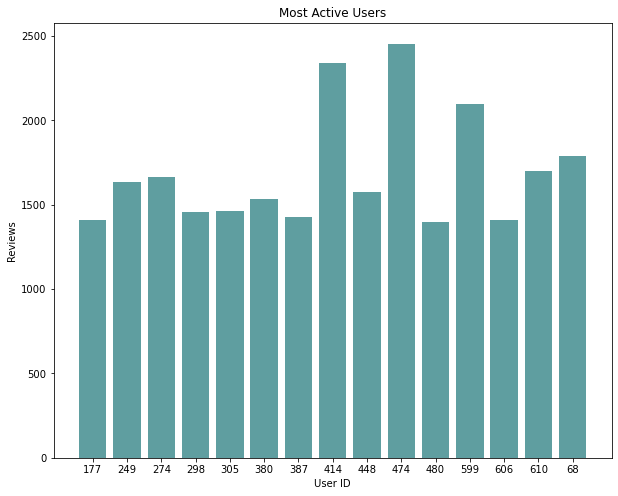

In [246]:
#making sorted df for chart
top_15_sorted = top_15_reviewers.sort_values('review_count')

#making airbnb_rating a string

grouped = top_15_sorted.groupby("userId")["review_count"].sum()

fig = plt.figure(figsize = (10, 8))

# create a bar plot
plt.bar(grouped.index, grouped.values, color="#5F9EA0")

# set the x-axis label
plt.xlabel("User ID")

# set the y-axis label
plt.ylabel("Reviews")

#adding title
plt.title("Most Active Users")

# show the plot
plt.show()

In [245]:
#using plotly to plot the top featurescolor=
fig = px.bar(top_15_sorted, x="userId", y="review_count")
fig.update_layout(title_text='Most Active Users', title_x=0.5,
                  xaxis_title="User Id", yaxis_title="Review Count")
fig.update_traces(marker_color = "#5F9EA0")
fig.show()